In [1]:
import os
import gc
import warnings

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
import scipy as sp
%matplotlib inline

import torch
from torch.optim import Adam
from torch.nn import MSELoss

from deepseries.models import WaveNet
from deepseries.train import Learner
from deepseries.dataset import TimeSeries, Property, SeriesFrame

In [2]:
DIR = "./data"
BATCH_SIZE = 128
DROP_BEFORE = 1200

LAGS = [28]
MAX_LAGS = max(LAGS)


ENC_LEN = 28 * 2
DEC_LEN = 28

VALID_LEN = 28
TEST_LEN = 28

TRAIN_LAST_DAY = 1913
USE_SERIES_LEN = TRAIN_LAST_DAY - DROP_BEFORE + 1 + 28

CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "int16", 'snap_TX': 'int16', 'snap_WI': 'int16' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

# FIRST_DAY = datetime(2011, 1, 29) 
# FORECAST_DAY = datetime(2016,4, 25) 

In [3]:
def load_data():
    label_encoders = {}
    
    prices = pd.read_csv(os.path.join(DIR, "sell_prices.csv"), dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(prices[col].astype(str).fillna("None"))
            prices[col] = label_encoders[col].transform(prices[col].astype(str).fillna("None")).astype("int16")
    
    cal = pd.read_csv(os.path.join(DIR, "calendar.csv"), dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(cal[col].astype(str).fillna("None"))
            cal[col] = label_encoders[col].transform(cal[col].astype(str).fillna("None")).astype("int16")
    
    start_day = max(1, DROP_BEFORE-MAX_LAGS)
    numcols = [f"d_{day}" for day in range(start_day, TRAIN_LAST_DAY+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv(os.path.join(DIR, "sales_train_validation.csv"), 
                     usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(dt[col].astype(str).fillna("None"))
            dt[col] = label_encoders[col].transform(dt[col].astype(str).fillna("None")).astype("int16")

    for day in range(TRAIN_LAST_DAY+1, TRAIN_LAST_DAY+28+1):
        dt[f"d_{day}"] = np.nan
    
    product = dt[catcols].copy()
    print(f"product shape {product.shape}")

    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")

    dt = dt.merge(cal[['d', 'wm_yr_wk']], on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    dt['d'] = dt['d'].str.replace('d_', '').astype("int32")
    price = dt.pivot(index="id", columns="d", values="sell_price")
    xy = dt.pivot(index="id", columns="d", values="sales")
    del dt; gc.collect()
    print(f"sale_xy shape {xy.shape}")
    print(f"price shape {price.shape}")

    cal_use_col = ['date', 'wday', 'month', 'year', 'event_name_1',
    'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
    'snap_WI']
    cal = cal[cal_use_col]
    cal['year'] = cal['year'] - cal['year'].min()
    cal['quarter'] = cal.date.dt.quarter
    cal = cal.drop("date", axis=1).T
    cal = cal[xy.columns]
    print(f"calendar shape {cal.shape}")
    
    submission = pd.read_csv(os.path.join(DIR, "sample_submission.csv"))
    print(f"submisson shape {submission.shape}")
    return xy, price, cal, product, submission

In [4]:
df_xy, df_price, df_calendar, df_product, df_sub = load_data()

product shape (30490, 6)
sale_xy shape (30490, 770)
price shape (30490, 770)
calendar shape (11, 770)
submisson shape (60980, 29)


## 缺失数据

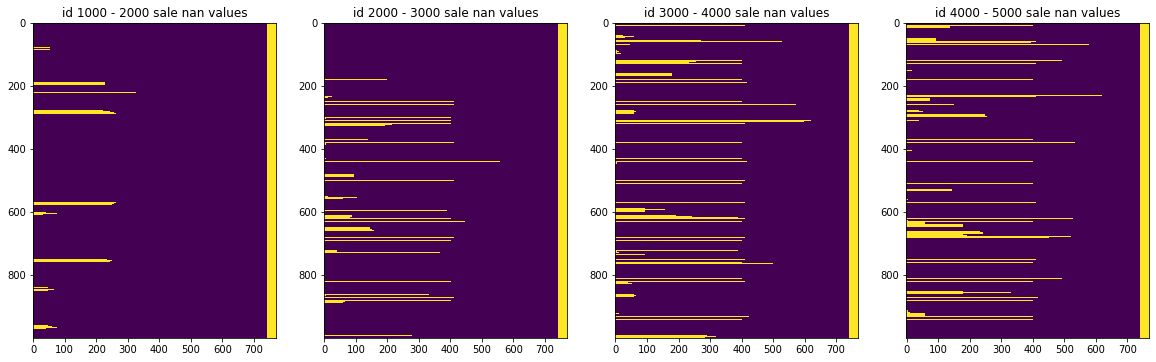

In [5]:
plt.figure(figsize=(20,20))

for i in range(1, 5):
    plt.subplot(int(f'14{i}'))
    plt.imshow(df_xy.isnull().values.astype(int)[i * 1000: (i+1)*1000])
    plt.title(f"id {i * 1000} - {(i+1) * 1000} sale nan values")

In [6]:
id_not_sell = df_xy.isnull().values.astype(int)
id_not_sell[:, -28:] = 0

Text(0.5, 1.0, 'each series num of nan')

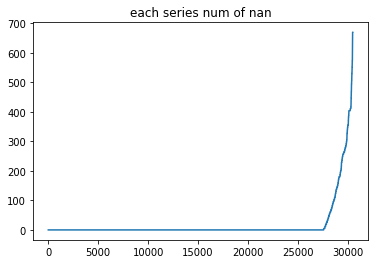

In [7]:
plt.plot(np.sort(id_not_sell.sum(axis=1)))
plt.title("each series num of nan")

In [8]:
pd.Series(id_not_sell.sum(axis=1)).describe()

count    30490.000000
mean        18.223614
std         72.079074
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        670.000000
dtype: float64

没有销售，同样没有价格

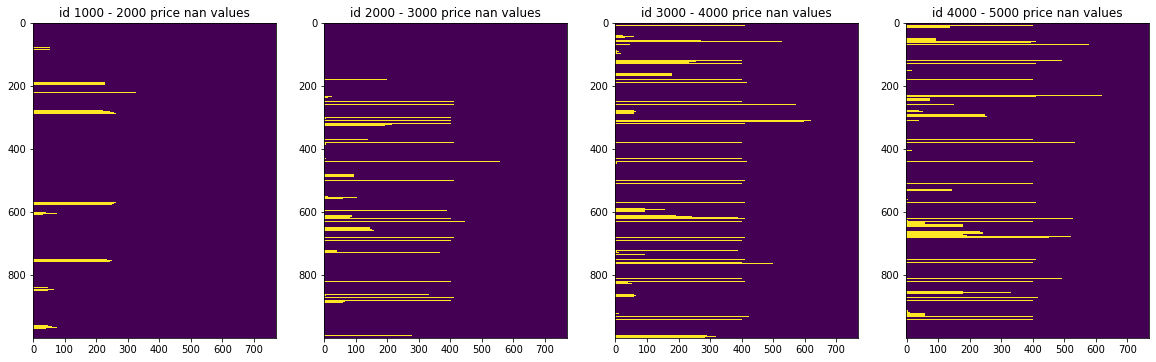

In [9]:
plt.figure(figsize=(20,20))

for i in range(1, 5):
    plt.subplot(int(f'14{i}'))
    plt.imshow(df_price.isnull().values.astype(int)[i * 1000: (i+1)*1000])
    plt.title(f"id {i * 1000} - {(i+1) * 1000} price nan values")

## 数据处理
- log1p
- 序列状态
- 序列统计指标
- 序列标准化

## 特征

### 时间序列状态
- 11_price
- 11_calendar
- 11_is_sell: 是否销售
- 10_is_zero: 是否为0销售
- 10_continue_zero: 为0第N天
- 10_lag_N：前N天销量
- 10_lag_M_rolling_N_mean/std: 窗口统计
- 品类销量
- 日期类

### 序列统计
- id 均值/中位数/偏度/峰度/分位数
- 365/90/30 自相关系数
- 品类下的日销排名/波动排名
- 品类下的价格排名


### Tips
- 特征标记{1,0}{1,0}{1,0}{1,0}
- #1 1 if use in encoder else 0
- #2 1 if use in decoder else 0
- #3 series(1), property(0)
- #4 num(1), categorical(0)

In [10]:
# series

xy = np.log1p(df_xy.values)
price = np.log1p(df_price.values)

/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until
/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log1p
  after removing the cwd from sys.path.


In [11]:
# series state
xy_nan = np.isnan(xy).astype("float32")
xy_zero = (xy == 0).astype("float32")

In [12]:
# series statistics

xy_valid_masked = np.ma.masked_array(xy, mask=xy_nan.astype(bool))

xy_mean = xy_valid_masked.mean(axis=1).data
xy_std = xy_valid_masked.std(axis=1).data
xy_skew = sp.stats.mstats.skew(xy_valid_masked, axis=1).data
xy_kurt = np.clip(sp.stats.mstats.kurtosis(xy_valid_masked, axis=1).data, None, 10)

In [13]:
# series normalization

xy = np.nan_to_num((xy - np.expand_dims(xy_mean, 1)) / (np.expand_dims(xy_std, 1) + 1e-6), 0.).astype("float32")

In [14]:
# series statistic features

xy_mean_mean = xy_mean.mean()
xy_mean_std = xy_mean.std()
xy_std_mean = xy_std.mean()
xy_std_std = xy_std.std()
xy_skew_mean = xy_skew.mean()
xy_skew_std = xy_skew.std()
xy_kurt_mean = xy_kurt.mean()
xy_kurt_std = xy_kurt.std()

f1101_xy_mean = (xy_mean - xy_mean_mean) / xy_mean_std
f1101_xy_std = (xy_std - xy_std_mean) / xy_std_std
f1101_xy_skew = (xy_skew - xy_skew_mean) / xy_skew_std
f1101_xy_kurt = (xy_kurt - xy_kurt_mean) / xy_kurt_std

f1101_xy_statistic = np.stack([f1101_xy_mean, f1101_xy_std, f1101_xy_skew, f1101_xy_kurt], 
                              axis=1).astype("float32")
f1011_xy_stats = np.stack([xy_nan, xy_zero], axis=1).astype("float32")[:, :, MAX_LAGS:]

del f1101_xy_mean; del f1101_xy_std; del f1101_xy_skew; del f1101_xy_kurt; gc.collect()

18392

In [15]:
# series lags

def create_lags(xy, n_lags):
    r = []
    for l in n_lags:
        lag = np.zeros_like(xy)
        lag[:, l:] = xy[:, :-l]
        r.append(lag)
    return np.stack(r, axis=1)

f1111_xy_lags = create_lags(xy, LAGS)[:, :, MAX_LAGS:].astype("float32")

In [16]:
# series categorical

f1100_xy_cate = df_product.set_index("id").values.astype("int64")

In [17]:
# series drop nan lag

xy = np.expand_dims(xy, 1)[:, :, MAX_LAGS:]

In [18]:
class ForwardSpliter:
    
    def split(self, time_idx, enc_len, dec_len, valid_size):
        if valid_size < 1:
            valid_size = int(np.floor(len(time_idx) * valid_size))
        valid_idx = time_idx[-(valid_size+enc_len):]
        train_idx = time_idx[:-valid_size]
        return train_idx, valid_idx

In [19]:
spliter = ForwardSpliter()

train_idx, valid_idx = spliter.split(np.arange(xy.shape[2]), ENC_LEN, DEC_LEN, VALID_LEN+TEST_LEN)
valid_idx, test_idx = spliter.split(valid_idx, ENC_LEN, DEC_LEN, TEST_LEN)

In [20]:
train_f1011_xy_stats = TimeSeries(f1011_xy_stats[:, :, train_idx])
valid_f1011_xy_stats = TimeSeries(f1011_xy_stats[:, :, valid_idx])
test_f1011_xy_stats = TimeSeries(f1011_xy_stats[:, :, test_idx])

train_f1101_xy_statistic = Property(f1101_xy_statistic)
valid_f1101_xy_statistic = Property(f1101_xy_statistic)
test_f1101_xy_statistic = Property(f1101_xy_statistic)

train_f1111_xy_lags = TimeSeries(f1111_xy_lags[:, :, train_idx])
valid_f1111_xy_lags = TimeSeries(f1111_xy_lags[:, :, valid_idx])
test_f1111_xy_lags = TimeSeries(f1111_xy_lags[:, :, test_idx])

train_f1100_xy_cate = Property(f1100_xy_cate)
valid_f1100_xy_cate = Property(f1100_xy_cate)
test_f1100_xy_cate = Property(f1100_xy_cate)

In [21]:
train_xy = TimeSeries(xy[:, :, train_idx])
valid_xy = TimeSeries(xy[:, :, valid_idx])
test_xy = TimeSeries(xy[:, :, test_idx])

In [22]:
train_dl = SeriesFrame(train_xy, BATCH_SIZE, ENC_LEN, DEC_LEN, time_free_space=4, 
                       enc_num_feats=[train_f1011_xy_stats, train_f1101_xy_statistic, train_f1111_xy_lags], 
                       enc_cat_feats=[train_f1100_xy_cate], 
                       dec_num_feats=[train_f1101_xy_statistic, train_f1111_xy_lags],
                       dec_cat_feats=[train_f1100_xy_cate],
                       use_cuda=True,
                      )

valid_dl = SeriesFrame(valid_xy, BATCH_SIZE, ENC_LEN, DEC_LEN, time_free_space=0, 
                       enc_num_feats=[valid_f1011_xy_stats, valid_f1101_xy_statistic, valid_f1111_xy_lags], 
                       enc_cat_feats=[valid_f1100_xy_cate], 
                       dec_num_feats=[valid_f1101_xy_statistic, valid_f1111_xy_lags],
                       dec_cat_feats=[valid_f1100_xy_cate], 
                       use_cuda=True,
                      )

test_dl = SeriesFrame(test_xy, BATCH_SIZE, ENC_LEN, DEC_LEN, time_free_space=0, 
                       enc_num_feats=[test_f1011_xy_stats, test_f1101_xy_statistic, test_f1111_xy_lags], 
                       enc_cat_feats=[test_f1100_xy_cate], 
                       dec_num_feats=[test_f1101_xy_statistic, test_f1111_xy_lags],
                       dec_cat_feats=[test_f1100_xy_cate],
                       mode='eval', use_cuda=True, shuffle=False,
                      )

In [23]:
model = WaveNet(enc_compress=32, dec_compress=32, 
                enc_numerical=7, 
                enc_categorical=[(3049, 16), (7, 1), (10, 1), (3, 1), (3, 1)],
                dec_numerical=5,
                dec_categorical=[(3049, 16), (7, 1), (10, 1), (3, 1), (3, 1)],
               )
opt = Adam(model.parameters(), 0.001)
loss_fn = MSELoss()
model.cuda()
learner = Learner(model, opt, loss_fn, '.', log_interval=100)
learner.fit(100, train_dl, valid_dl, patient=10, start_save=1)

epoch 1 / 100, batch  41%, train loss 0.9470
epoch 1 / 100, batch  83%, train loss 0.9406
epoch 1 / 100, batch 100%, train_loss 0.9384, valid loss 1.1003
epoch 2 / 100, batch  25%, train loss 0.9152
epoch 2 / 100, batch  67%, train loss 0.9194
epoch 2 / 100, batch 100%, train_loss 0.9193, valid loss 1.0955
epoch 3 / 100, batch   9%, train loss 0.9469
epoch 3 / 100, batch  51%, train loss 0.9169
epoch 3 / 100, batch  92%, train loss 0.9182
epoch 3 / 100, batch 100%, train_loss 0.9203, valid loss 1.0900
epoch 4 / 100, batch  34%, train loss 0.9244
epoch 4 / 100, batch  76%, train loss 0.9150
epoch 4 / 100, batch 100%, train_loss 0.9129, valid loss 1.0968
epoch 5 / 100, batch  18%, train loss 0.9235
epoch 5 / 100, batch  60%, train loss 0.9210
epoch 5 / 100, batch 100%, train_loss 0.9233, valid loss 1.0906
epoch 6 / 100, batch   2%, train loss 0.9477
epoch 6 / 100, batch  44%, train loss 0.9165
epoch 6 / 100, batch  85%, train loss 0.9124
epoch 6 / 100, batch 100%, train_loss 0.9118, vali

early stopping!
training finished, best epoch 24, best valid loss 1.0810


In [25]:
learner.load("./checkpoints/model-epoch-24.pkl")

In [95]:
def predict_submission(model, test_dl):
    model.eval()
    test_dl.eval()
    preds = []
    for batch in test_dl:
        preds.append(model.predict(**batch).cpu().detach().numpy())
    preds = np.concatenate(preds, axis=0).squeeze()
    preds = np.expm1(preds * np.expand_dims(xy_std, 1) + np.expand_dims(xy_mean, 1))
    return preds

preds = predict_submission(learner.model, test_dl)

In [98]:
xy_id_sort = pd.Series(np.arange(df_xy.shape[0]), index=df_xy.index)[df_sub.iloc[:df_xy.shape[0]].id.values]

In [127]:
df_sub.iloc[:df_xy.shape[0], 1:] = preds[xy_id_sort]
df_sub.iloc[df_xy.shape[0]:, 1:] = preds[xy_id_sort]

In [128]:
df_sub.to_csv("./data/sub_0412_1.csv", index=False)

In [124]:
np.all(df_xy.iloc[xy_id_sort].index.values == df_sub.id.values[:df_xy.shape[0]])

True

In [129]:
pd.read_csv("./data/submission_top1.csv")

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.910026,0.847982,0.850890,0.801789,1.071719,1.296671,1.350886,1.009637,0.970509,...,1.112975,1.385381,1.294539,0.993150,0.869451,0.849285,0.855230,1.022105,1.262562,1.233375
1,FOODS_1_001_CA_2_validation,0.940942,0.954666,0.882539,1.273918,1.290628,1.354433,1.554513,0.920688,0.926300,...,1.208342,1.641095,1.501229,1.032052,0.982766,1.012417,1.052117,1.241158,1.689393,1.424921
2,FOODS_1_001_CA_3_validation,1.091795,1.044925,0.949970,0.917520,0.990185,1.107758,1.223882,1.105829,1.137468,...,1.132724,1.674212,1.766982,1.147176,1.055445,0.980131,0.969123,1.054151,1.391111,1.266828
3,FOODS_1_001_CA_4_validation,0.414818,0.361572,0.355099,0.349345,0.405143,0.451183,0.517519,0.398493,0.426824,...,0.457459,0.482851,0.500463,0.385219,0.363917,0.368164,0.373390,0.419760,0.457920,0.481183
4,FOODS_1_001_TX_1_validation,0.180371,0.179159,0.170700,0.171773,0.172805,0.180151,0.228228,0.476832,0.429286,...,0.393753,0.380485,0.353399,0.295464,0.280412,0.275795,0.272560,0.278792,0.331847,0.318894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,HOUSEHOLD_2_516_TX_2_evaluation,0.274168,0.255272,0.267714,0.273158,0.336000,0.432771,0.327343,0.228226,0.221530,...,0.279047,0.372095,0.330364,0.245969,0.223520,0.234043,0.226027,0.280163,0.368250,0.339974
60976,HOUSEHOLD_2_516_TX_3_evaluation,0.186414,0.172493,0.180416,0.171298,0.202652,0.235260,0.159966,0.127921,0.116302,...,0.164179,0.191023,0.170427,0.143703,0.139419,0.141908,0.145095,0.177965,0.207824,0.187936
60977,HOUSEHOLD_2_516_WI_1_evaluation,0.085410,0.080320,0.080041,0.082909,0.099185,0.112486,0.096555,0.091648,0.086087,...,0.124481,0.136940,0.131141,0.089666,0.085207,0.085014,0.087650,0.131066,0.145694,0.139324
60978,HOUSEHOLD_2_516_WI_2_evaluation,0.042673,0.041077,0.038520,0.081031,0.096036,0.097185,0.091333,0.088256,0.085207,...,0.124607,0.119812,0.110457,0.095534,0.091108,0.088967,0.076782,0.101013,0.101227,0.095689


In [136]:
top1 = pd.read_csv("./data/submission_top1.csv").iloc[:30490]

In [181]:
def plot(idx):
    plt.figure(figsize=(16, 5))
    plt.plot(df_xy.iloc[idx, -56:-28].values)
    plt.plot(np.arange(28, 56), preds[idx], label='wave')
    plt.plot(np.arange(28, 56), top1.iloc[idx, 1:].values, label='lgb')
    plt.legend()

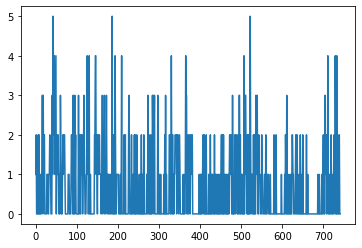

In [185]:
plt.plot(df_xy.iloc[3000, :-28].values)

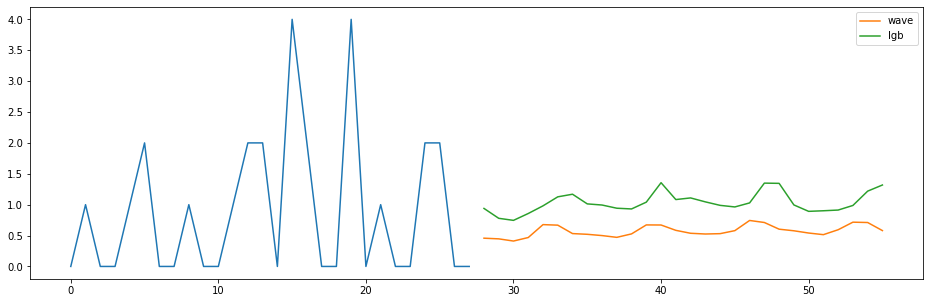

In [184]:
plot(3000)

In [163]:
df_xy.mean(axis=1).mean()

1.2561647366396398

In [165]:
masked_xy = np.ma.array(df_xy, mask=(df_xy.values == 0) | (df_xy.isnull().values))
masked_xy.mean(axis=1).mean()

2.3495803948411016

In [166]:
masked_xy = np.ma.array(df_xy, mask=(df_xy.isnull().values))
masked_xy.mean(axis=1).mean()

1.2561647366396433

In [168]:
df_xy.shape

(30490, 770)

In [180]:
xy.squeeze().mean(axis=1)

array([-0.01272562, -0.00423296, -0.00420088, ..., -0.00084591,
        0.00742923,  0.00394681], dtype=float32)

In [155]:
df_xy

d,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,...,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941
id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001_CA_1_validation,0.0,1.0,6.0,2.0,0.0,3.0,1.0,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOODS_1_001_CA_2_validation,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOODS_1_001_CA_3_validation,0.0,2.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOODS_1_001_CA_4_validation,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOODS_1_001_TX_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_516_TX_2_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOUSEHOLD_2_516_TX_3_validation,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOUSEHOLD_2_516_WI_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
preds.mean()

1.0102627681225906

In [147]:
top1.iloc[:, 1:].mean().mean()

1.4331789663311454

In [137]:
top1

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.910026,0.847982,0.850890,0.801789,1.071719,1.296671,1.350886,1.009637,0.970509,...,1.112975,1.385381,1.294539,0.993150,0.869451,0.849285,0.855230,1.022105,1.262562,1.233375
1,FOODS_1_001_CA_2_validation,0.940942,0.954666,0.882539,1.273918,1.290628,1.354433,1.554513,0.920688,0.926300,...,1.208342,1.641095,1.501229,1.032052,0.982766,1.012417,1.052117,1.241158,1.689393,1.424921
2,FOODS_1_001_CA_3_validation,1.091795,1.044925,0.949970,0.917520,0.990185,1.107758,1.223882,1.105829,1.137468,...,1.132724,1.674212,1.766982,1.147176,1.055445,0.980131,0.969123,1.054151,1.391111,1.266828
3,FOODS_1_001_CA_4_validation,0.414818,0.361572,0.355099,0.349345,0.405143,0.451183,0.517519,0.398493,0.426824,...,0.457459,0.482851,0.500463,0.385219,0.363917,0.368164,0.373390,0.419760,0.457920,0.481183
4,FOODS_1_001_TX_1_validation,0.180371,0.179159,0.170700,0.171773,0.172805,0.180151,0.228228,0.476832,0.429286,...,0.393753,0.380485,0.353399,0.295464,0.280412,0.275795,0.272560,0.278792,0.331847,0.318894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.274168,0.255272,0.267714,0.273158,0.336000,0.432771,0.327343,0.228226,0.221530,...,0.279047,0.372095,0.330364,0.245969,0.223520,0.234043,0.226027,0.280163,0.368250,0.339974
30486,HOUSEHOLD_2_516_TX_3_validation,0.186414,0.172493,0.180416,0.171298,0.202652,0.235260,0.159966,0.127921,0.116302,...,0.164179,0.191023,0.170427,0.143703,0.139419,0.141908,0.145095,0.177965,0.207824,0.187936
30487,HOUSEHOLD_2_516_WI_1_validation,0.085410,0.080320,0.080041,0.082909,0.099185,0.112486,0.096555,0.091648,0.086087,...,0.124481,0.136940,0.131141,0.089666,0.085207,0.085014,0.087650,0.131066,0.145694,0.139324
30488,HOUSEHOLD_2_516_WI_2_validation,0.042673,0.041077,0.038520,0.081031,0.096036,0.097185,0.091333,0.088256,0.085207,...,0.124607,0.119812,0.110457,0.095534,0.091108,0.088967,0.076782,0.101013,0.101227,0.095689


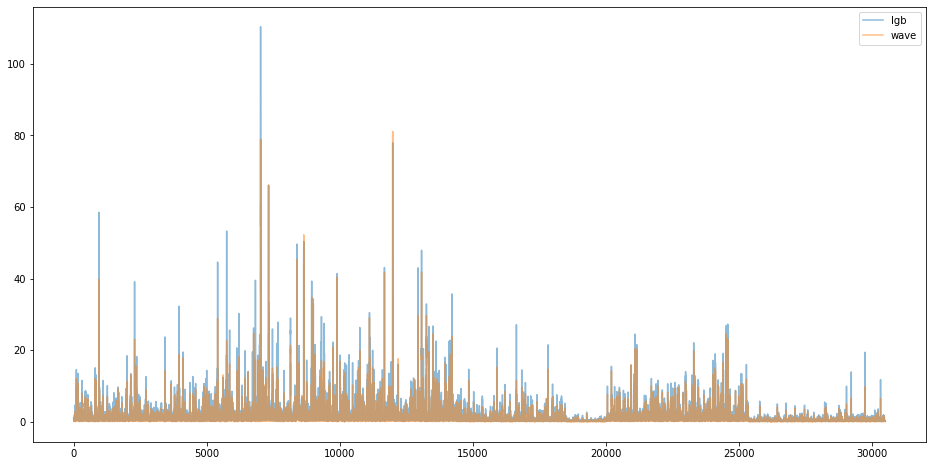

In [135]:

plt.figure(figsize=(16, 8))
plt.plot(pd.read_csv("./data/submission_top1.csv").mean(1).iloc[:30490], alpha=0.5, label='lgb')
plt.plot(pd.DataFrame(preds).mean(1), label='wave', alpha=0.5)
# plt.figure(figsize=(16, 2))
# plt.plot(df_xy.dropna(axis=1).iloc[:, -28:].mean(1).values, label='enc', alpha=0.5)
# plt.figure(figsize=(16, 2))
# plt.plot(df_xy.dropna(axis=1).iloc[:, ].mean(1).values, label='all', alpha=0.5)
# plt.figure(figsize=(16, 2))
# plt.plot(xy_mean)
plt.legend()

In [24]:


# sort_id = pd.Series(dict(zip(np.arange(df_xy.shape[0]), sub_ids.sort_values().index.values))).values

# pd.DataFrame(preds[sort_id]).mean(axis=1)

# pd.DataFrame(preds).mean(axis=1)

# df_xy.mean(axis=1)

# pd.DataFrame({'sub_ids': sub_ids, 'xy_ids': xy_ids})

# pd.read_csv("./data/submission_top1.csv").set_index("id").mean().mean()

# pd.DataFrame(sub_ids).reset_index()

# xy_ids = pd.Series(df_xy.index.values)

# df_sub.iloc[: preds.shape[0], 1:] = preds
# df_sub.iloc[preds.shape[0]:, 1:] = preds

# df_sub.to_csv("./data/sub_0412_1.csv", index=None)

